In [1]:
import control

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
num = np.array([8])
den = np.array([1, 1.6, 4])

Gs = control.tf(num, den)
Gs

TransferFunction(array([8]), array([1. , 1.6, 4. ]))

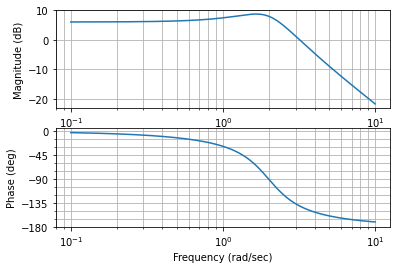

In [45]:
# Bode diagram
control.bode(Gs, dB=True, Hz=False, omega_limits=(0.1, 10), plot=True);

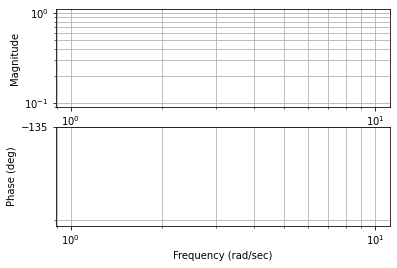

In [5]:
m = control.bode(Gs, omega=3.333)

In [6]:
m

(array([0.90021244]), array([-2.49798953]), array([3.333]))

In [7]:
m[1] * 180 / 3.14159265

array([-143.1242574])

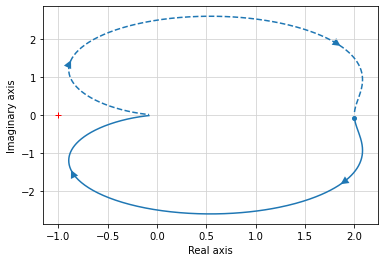

In [8]:
# Nyquist diagram
control.nyquist(Gs, omega_limits=(0.1, 10), plot=True);

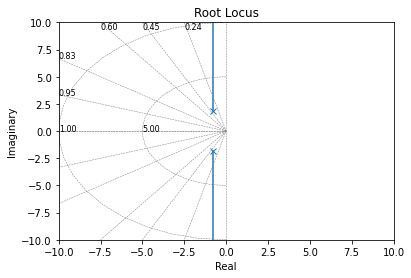

In [9]:
# Root locus
control.rlocus(Gs, kvect=np.linspace(0, 10, 1000), xlim=(-10, 10), ylim=(-10, 10), plot=True);

In [10]:
# Margin gain and phase
'''
    gm (float) – Gain margin

    pm (float) – Phase margin (in degrees)

    wcg (float or array_like) – Crossover frequency associated with gain margin (phase crossover frequency), where phase crosses below -180 degrees.

    wcp (float or array_like) – Crossover frequency associated with phase margin (gain crossover frequency), where gain crosses below 1.
'''

gm, pm, wcg, wcp = control.margin(Gs)
print('Margem de ganho: ', gm)
print('Margem de fase: ', str(pm) + ' graus')
print('Frequência associada com a margem de ganho: ', str(wcg) + ' Rad/seg')
print('Frequência associada com a margem de fase: ', str(wcp) + ' Rad/seg')

Margem de ganho:  inf
Margem de fase:  39.61231058053758 graus
Frequência associada com a margem de ganho:  nan Rad/seg
Frequência associada com a margem de fase:  3.1879476381760603 Rad/seg


Questão 2

O teorema do valor final diz que:

   lim_{t->inf}f(t) = lim_{s->0}sF(s)
   
   onde f(t) é a resposta ao degrau e F(s) é a função de transferência

Para o sistema em questão, temos:

   lim_{t->inf}y(t) = lim_{s->0}sY(s)

   onde y(t) é a resposta ao degrau e Y(s) é a função de transferência

Considerando um controlador PD da forma:

   C(s) = (Kp + Kd*s)E(s)

Temos o seguinte sistema compensado:

   Gc(s) = G(s)C(s) = (Kp + Kds)E(s)*G(s)

   Gc(s) = (Kp + Kds)E(s)8 / (s^2 + 1,6s + 4)

   Pelo teorema do valor final:

   val_final = lim_{s->0}{s(Kp + Kds)E(s)8 / (s^2 + 1,6s + 4)}

   Considerando E(s) = 1/s:

   val_final = lim_{s->0}{(Kp + Kds)8 / (s^2 + 1,6s + 4)} = 8/4 = 2

Portanto com um controlador PD não e possivel zerar o erro em regime permanente, visto que ele não adiciona um polo na origem
   


In [11]:
#PD controller
Kp = 1
Kd = 0.1
C = control.tf([Kd, Kp],[1])
C

TransferFunction(array([0.1, 1. ]), array([1]))

In [12]:
Gc = control.series(C, Gs)
Gc

TransferFunction(array([0.8, 8. ]), array([1. , 1.6, 4. ]))

In [13]:
#Reposta ao degrau
yout, T = control.step_response(Gc)

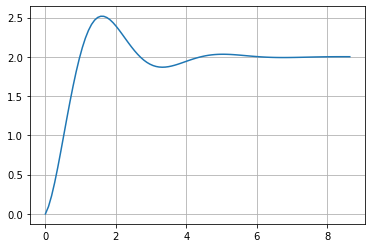

In [14]:
plt.plot(yout,T)
plt.grid()

Considerando o controlador:
    C(s) = a1s + a0 / b1s + 1

    1. Nova frequência de cruzamento de ganho: 2 rad/s

    2. Margem de Fase: 60°

    3. Adote o valor de a0 = 0,8

    Com isso ja temos: 

    C(s) = a1s + 0.8 / b1s + 1

Dados do sistema sem controlador:

Margem de ganho:  inf

Margem de fase:  39.61231058053758 graus

Frequência associada com a margem de ganho:  nan Rad/seg

Frequência associada com a margem de fase:  3.1879476381760603 Rad/seg

In [65]:
a0 = 0.8

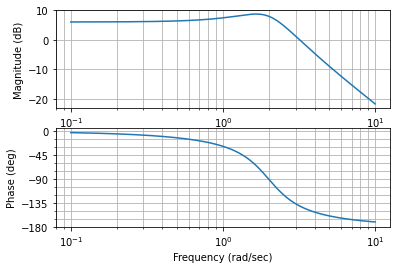

In [90]:
# Bode diagram
control.bode(Gs, dB=True, Hz=False, omega_limits=(0.1, 10), plot=True);

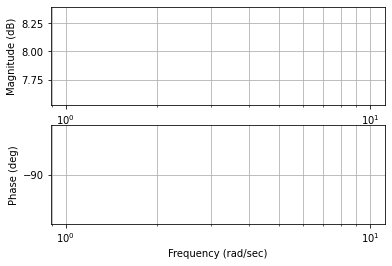

In [92]:
magJW, phase, omega = control.bode(Gs, dB =True,omega = 2)

In [76]:
phase * (180 / 3.14159265)

array([-90.0000001])

In [93]:
magJW

array([2.5])

In [79]:
#Temos 
phi = -180 + 60 - (phase[0] * (180 / 3.14159265))
phi

-29.99999989716001

In [94]:
magJW

array([2.5])

In [95]:
phase

array([-1.57079633])

In [96]:
from math import pi


SatJW = 2j
SatJW

2j

In [97]:
absGsJW = abs(8 / ((SatJW)**2 + 1.6*SatJW +4))
absGsJW

2.5

In [44]:
wcp

3.1879476381760603

In [98]:
# Calculo do a1

from math import cos, pi, sin


a_1 = (1 - a0*absGsJW*cos(phi*(pi/180)))/((2*(180/pi))*absGsJW*sin(phi*(pi/180)))
a_1 

0.0020876798290821136

In [99]:
#Calculando b1
b_1 = (cos(phi*(pi/180)) - a0*abs(magJW))/((2*(180/pi))*sin(phi*(pi/180)))
b_1 = b_1[0]
b_1

0.011064944096698972

In [100]:
Cav = control.tf([a_1, a0], [b_1, 1])
Cav

TransferFunction(array([0.00208768, 0.6       ]), array([0.01106494, 1.        ]))

In [101]:
SisCont = control.series(Gs, Cav)
SisCont

TransferFunction(array([0.01670144, 4.8       ]), array([0.01106494, 1.01770391, 1.64425978, 4.        ]))

In [83]:
yout1, T1 = control.step_response(SisCont)

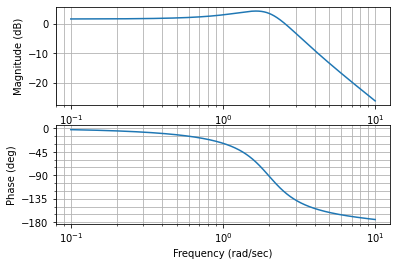

In [102]:
# Bode diagram
control.bode(SisCont, dB=True, Hz=False, omega_limits=(0.1, 10), plot=True);

In [103]:
gm1, pm1, wcg1, wcp1 = control.margin(SisCont)
print('Margem de ganho: ', gm1)
print('Margem de fase: ', str(pm1) + ' graus')
print('Frequência associada com a margem de ganho: ', str(wcg1) + ' Rad/seg')
print('Frequência associada com a margem de fase: ', str(wcp1) + ' Rad/seg')

Margem de ganho:  45.10943704643445
Margem de fase:  57.24343404734606 graus
Frequência associada com a margem de ganho:  14.720361890569501 Rad/seg
Frequência associada com a margem de fase:  2.552961135949496 Rad/seg


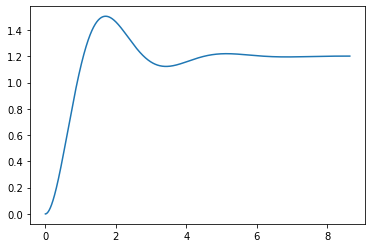

In [86]:
plt.plot(yout1, T1)